In [2]:
#REading a .fif file with MNE
import warnings
warnings.filterwarnings('ignore')
import mne
import numpy as np
import matplotlib.pyplot as plt
import os
import pandas as pd
import seaborn as sns
from datetime import datetime
import eegraph
from mne import export

from mne.datasets.fieldtrip_cmc import data_path
from mne_connectivity import spectral_connectivity_epochs

In [23]:
#Reading .fif
raw=mne.io.read_raw_fif('/home/pablo/Documents/Universidad Data/Maestría en Matemáticas Aplicadas/Tesis/data/Pat28_seizure_segment_raw.fif', preload=True)
raw.pick_types(eeg=True, bio=False, misc=False)
channels_1=raw.ch_names
#For seeg signals
#Channels to drop from preprocessing inspection
channels_to_drop=['EEG 008', 'EEG 009', 'EEG 029', 'EEG 051', 'EEG 082', 'EEG 102', 'EEG 103', 'EEG 104', 'EEG 105']
#data without outlier channes   
raw.drop_channels(channels_to_drop)

Opening raw data file /home/pablo/Documents/Universidad Data/Maestría en Matemáticas Aplicadas/Tesis/data/Pat28_seizure_segment_raw.fif...
Isotrak not found
    Range : 6448128 ... 7062528 =   6297.000 ...  6897.000 secs
Ready.
Reading 0 ... 614400  =      0.000 ...   600.000 secs...
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).


Measurement date,Unknown
Experimenter,Unknown
Participant,Unknown
Digitized points,Not available
Good channels,97 EEG
Bad channels,None
EOG channels,Not available
ECG channels,Not available
Sampling frequency,1024.00 Hz
Highpass,0.00 Hz
Lowpass,512.00 Hz


Not setting metadata
12 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 12 events and 51200 original time points ...
0 bad epochs dropped
Not setting metadata
12 matching events found
No baseline correction applied
0 projection items activated
combining channels using "mean"


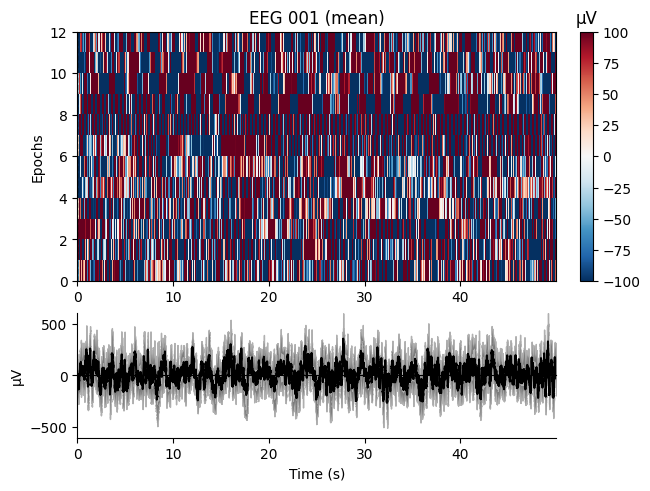

[<Figure size 640x480 with 3 Axes>]

In [30]:
epochs=mne.make_fixed_length_epochs(raw, duration=50.0, preload=True)
epochs.plot_image(picks=['EEG 001'], combine='mean', vmin=-100, vmax=100, cmap='RdBu_r')

In [41]:
#Interesting channels according to wpli
signals_a= [idx
    for idx, ch_info in enumerate(epochs.info["chs"])
    if ch_info["ch_name"] == "EEG 062" or ch_info["ch_name"] == "EEG 063" or ch_info["ch_name"] == "EEG 064" or ch_info["ch_name"] == "EEG 065" or ch_info["ch_name"] == "EEG 066"
]

signals_b= [idx
    for idx, ch_info in enumerate(epochs.info["chs"])
    if ch_info["ch_name"] == "EEG 052" or ch_info["ch_name"] == "EEG 053" or ch_info["ch_name"] == "EEG 054" or ch_info["ch_name"] == "EEG 055" or ch_info["ch_name"] == "EEG 056"
]

In [43]:
#Forma 1

indices_ab = (np.array([signals_a]), np.array([signals_b]))  # A => B
indices_ba = (np.array([signals_b]), np.array([signals_a]))  # B => A
gc_ab = spectral_connectivity_epochs(
    epochs,
    method=["gc"],
    indices=indices_ab,
    fmin=5,
    fmax=30,
    rank=(np.array([5]), np.array([5])),
    gc_n_lags=20,
)  # A => B
gc_ba = spectral_connectivity_epochs(
    epochs,
    method=["gc"],
    indices=indices_ba,
    fmin=5,
    fmax=30,
    rank=(np.array([5]), np.array([5])),
    gc_n_lags=20,
)  # B => A
freqs = gc_ab.freqs

Replacing existing metadata with 3 columns
Connectivity computation...
    computing connectivity for 1 connections
    using t=0.000s..49.999s for estimation (51200 points)
    frequencies: 5.0Hz..30.0Hz (1251 points)
    Using multitaper spectrum estimation with 7 DPSS windows
    the following metrics will be computed: GC
    computing cross-spectral density for epoch 1
    computing cross-spectral density for epoch 2
    computing cross-spectral density for epoch 3
    computing cross-spectral density for epoch 4
    computing cross-spectral density for epoch 5
    computing cross-spectral density for epoch 6
    computing cross-spectral density for epoch 7
    computing cross-spectral density for epoch 8
    computing cross-spectral density for epoch 9
    computing cross-spectral density for epoch 10
    computing cross-spectral density for epoch 11
    computing cross-spectral density for epoch 12
Computing GC for connection 1 of 1


100%|██████████| frequency blocks : 1251/1251 [00:26<00:00,   46.72it/s]


[Connectivity computation done]
Replacing existing metadata with 3 columns
Connectivity computation...
    computing connectivity for 1 connections
    using t=0.000s..49.999s for estimation (51200 points)
    frequencies: 5.0Hz..30.0Hz (1251 points)
    Using multitaper spectrum estimation with 7 DPSS windows
    the following metrics will be computed: GC
    computing cross-spectral density for epoch 1
    computing cross-spectral density for epoch 2
    computing cross-spectral density for epoch 3
    computing cross-spectral density for epoch 4
    computing cross-spectral density for epoch 5
    computing cross-spectral density for epoch 6
    computing cross-spectral density for epoch 7
    computing cross-spectral density for epoch 8
    computing cross-spectral density for epoch 9
    computing cross-spectral density for epoch 10
    computing cross-spectral density for epoch 11
    computing cross-spectral density for epoch 12
Computing GC for connection 1 of 1


100%|██████████| frequency blocks : 1251/1251 [00:19<00:00,   64.78it/s]


[Connectivity computation done]


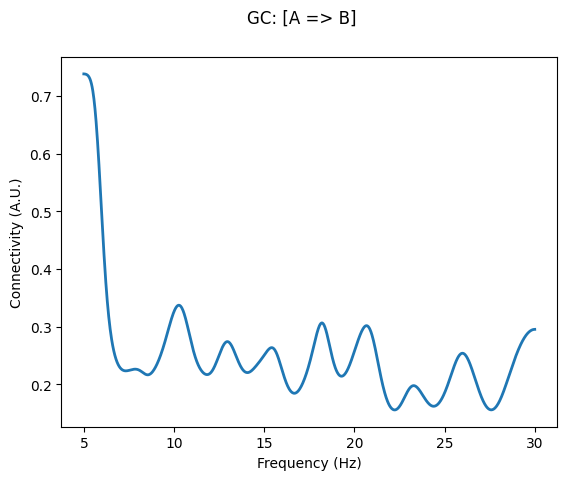

In [46]:
fig, axis = plt.subplots(1, 1)
axis.plot(freqs, gc_ab.get_data()[0], linewidth=2)
axis.set_xlabel("Frequency (Hz)")
axis.set_ylabel("Connectivity (A.U.)")
fig.suptitle("GC: [A => B]")
plt.show()

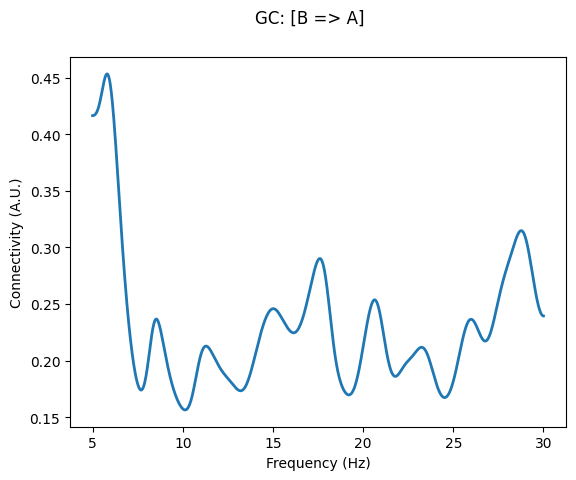

In [47]:
fig, axis = plt.subplots(1, 1)
axis.plot(freqs, gc_ba.get_data()[0], linewidth=2)
axis.set_xlabel("Frequency (Hz)")
axis.set_ylabel("Connectivity (A.U.)")
fig.suptitle("GC: [B => A]")
plt.show()

Drivers and receivers

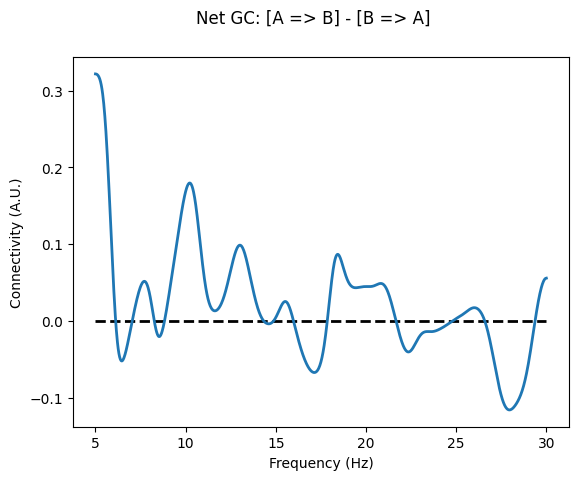

In [50]:
net_gc = gc_ab.get_data() - gc_ba.get_data()  # [A => B] - [B => A]

fig, axis = plt.subplots(1, 1)
axis.plot((freqs[0], freqs[-1]), (0, 0), linewidth=2, linestyle="--", color="k")
axis.plot(freqs, net_gc[0], linewidth=2)
axis.set_xlabel("Frequency (Hz)")
axis.set_ylabel("Connectivity (A.U.)")
fig.suptitle("Net GC: [A => B] - [B => A]")
plt.show()

In [66]:
sfreq = epochs.info["sfreq"]  # the sampling frequency
tmin = 0.0  # exclude the baseline period for connectivity estimation
Freq_Bands = {"theta": [4.0, 8.0]}  # frequency of interest

n_freq_bands = len(Freq_Bands)
min_freq = np.min(list(Freq_Bands.values()))
max_freq = np.max(list(Freq_Bands.values()))

# Prepare the freq points
freqs = np.linspace(min_freq, max_freq, int((max_freq - min_freq) * 4 + 1))

fmin = tuple([list(Freq_Bands.values())[f][0] for f in range(len(Freq_Bands))])
fmax = tuple([list(Freq_Bands.values())[f][1] for f in range(len(Freq_Bands))])

# We specify the connectivity measurements
connectivity_methods = ["gc"]
n_con_methods = len(connectivity_methods)


#Interesting channels according

# Compute connectivity over trials
con_epochs = spectral_connectivity_epochs(
    epochs,
    method=connectivity_methods,
    sfreq=sfreq,
    indices=indices_ab,
    fmin=fmin,
    fmax=fmax
)

Replacing existing metadata with 3 columns
Connectivity computation...
    computing connectivity for 1 connections
    using t=0.000s..49.999s for estimation (51200 points)
    frequencies: 4.0Hz..8.0Hz (201 points)
Estimated data ranks:
    connection 1 - seeds (5); targets (5)
    Using multitaper spectrum estimation with 7 DPSS windows
    the following metrics will be computed: GC
    computing cross-spectral density for epoch 1
    computing cross-spectral density for epoch 2
    computing cross-spectral density for epoch 3
    computing cross-spectral density for epoch 4
    computing cross-spectral density for epoch 5
    computing cross-spectral density for epoch 6
    computing cross-spectral density for epoch 7
    computing cross-spectral density for epoch 8
    computing cross-spectral density for epoch 9
    computing cross-spectral density for epoch 10
    computing cross-spectral density for epoch 11
    computing cross-spectral density for epoch 12
Computing GC for con

100%|██████████| frequency blocks : 201/201 [00:48<00:00,    4.18it/s]

[Connectivity computation done]


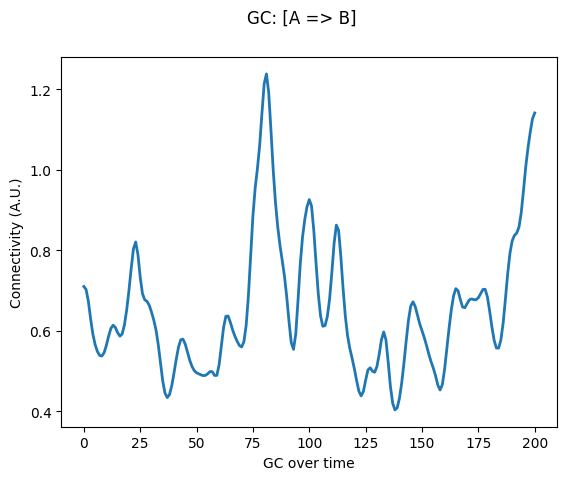

In [81]:
con_data=np.sum(con_epochs.get_data(output="raveled"), axis=0)
#plotting
fig, axis = plt.subplots(1, 1)
axis.plot(con_data, linewidth=2)
axis.set_xlabel("GC over time")
axis.set_ylabel("Connectivity (A.U.)")
fig.suptitle("GC: [A => B]")
plt.show()